In [1]:
import xarray as xr
import xcdat as xc
import numpy as np
import xskillscore as xs

In [2]:
f_a = '/Users/zhang40/Downloads/ERA5-TREFHT-ANN-land_test_30yrs.nc' 
f_b = '/Users/zhang40/Downloads/ERA5-TREFHT-ANN-land_ref_30yrs.nc' 

In [3]:
sst_a = xr.open_dataset(f_a)
sst_b = xr.open_dataset(f_b)

In [4]:
output_grid = sst_a.regridder.grid
sst_b["mask"] = xr.where(~np.isnan(sst_b.TREFHT), 1, 0)
sst_b_regrid_bilinear = sst_b.regridder.horizontal(
            'TREFHT', output_grid, tool='xesmf', method='bilinear'
        )

sst_b_regrid_conservative_normed = sst_b.regridder.horizontal(
            'TREFHT', output_grid, tool='xesmf', method='conservative_normed'
        )

sst_b_regrid_conservative = sst_b.regridder.horizontal(
            'TREFHT', output_grid, tool='xesmf', method='conservative'
        )

In [5]:
result_xr_bilinear = xs.rmse(sst_a['TREFHT'], sst_b_regrid_conservative['TREFHT'], dim=["lat", "lon"], weights=None, skipna=True)
print('result_xr_bilinear', result_xr_bilinear.values)

result_xr_conservative_normed = xs.rmse(sst_a['TREFHT'], sst_b_regrid_conservative_normed['TREFHT'], dim=["lat", "lon"], weights=None, skipna=True)
print('result_xr_conservative_normed', result_xr_conservative_normed.values)

result_xr_conservative = xs.rmse(sst_a['TREFHT'], sst_b_regrid_conservative['TREFHT'], dim=["lat", "lon"], weights=None, skipna=True)
print('result_xr_conservative', result_xr_conservative.values)


result_xr_bilinear 2.0316942
result_xr_conservative_normed 1.8655692
result_xr_conservative 2.0316942


In [6]:
# Calculate area-weighted integral after Conservative Normed regriding

weights = sst_b_regrid_conservative_normed.spatial.get_weights(["X", "Y"], data_var='TREFHT')
area_weighted_integral_normed = (sst_b_regrid_conservative_normed['TREFHT'].fillna(0) * weights).sum(dim=["lat", "lon"])
area_weighted_integral_normed

# Calculate area-weighted integral after Conservative regriding

weights = sst_b_regrid_conservative_normed.spatial.get_weights(["X", "Y"], data_var='TREFHT')
area_weighted_integral = (sst_b_regrid_conservative['TREFHT'].fillna(0) * weights).sum(dim=["lat", "lon"])
area_weighted_integral

# Calculate area-weighted integral of original field
sst_b = sst_b.bounds.add_missing_bounds()
weights0 = sst_b.spatial.get_weights(["X", "Y"], data_var='TREFHT')
area_weighted_integral0 = (sst_b['TREFHT'].fillna(0) * weights0).sum(dim=["lat", "lon"])
area_weighted_integral0


print('area_weighted_integral before regriding',area_weighted_integral0.values)
print('area_weighted_integral after conservative normed regriding',area_weighted_integral_normed.values)
print('area_weighted_integral after conservative regriding',area_weighted_integral.values)


area_weighted_integral before regriding 1771.0478512460697
area_weighted_integral after conservative normed regriding 1967.657722299664
area_weighted_integral after conservative regriding 1770.978281113709


/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/zhang40/mambaforge/envs/e3sm-unified/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


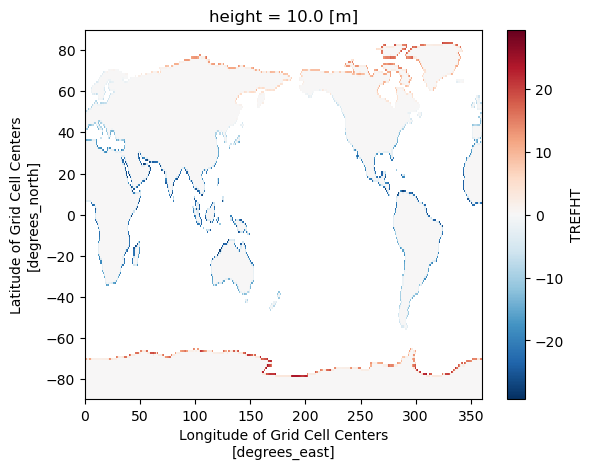

In [7]:
(sst_b_regrid_conservative.TREFHT-sst_b_regrid_conservative_normed.TREFHT).plot()